# AI for Earth System Science Hackathon 2020
# GOES Challenge
David John Gagne, Gunther Wallach, Charlie Becker, Bill Petzke

## Introduction
![GOES-R satellite image from Wikipedia](goes_images/GOES-R_SPACECRAFT.jpg)

Lightning kills roughly 30 people per year in the United States (https://www.weather.gov/safety/lightning-victims) and can have large economic impacts by disrupting outdoor work and events and by sparking fires. Improved short term prediction of lightning onset can help protect life and property by ensuring that people can get to safety with sufficient lead time. The economic impacts of lightning protection practices can also be reduced by improving the prediction of when lightning is expected to end. 

Recently deployed observational systems combined with advances in machine learning have the potential to improve the short-term prediction of lightning by associating broader scale weather patterns with the future occurrence of lightning in that area. The Geostationary Operational Environmental Satellite 16 (GOES-16) is a weather satellite that orbits the Earth at a fixed point situated along the same longitude as the Eastern United States and can provide a hemispheric, multispectral view of cloud patterns at high space and time resolution through its Advanced Baseline Imager (ABI) camera. The satellite also holds the Geostationary Lightning Mapper (GLM) instrument that records lightning flashes across the hemispheric view of the satellite. By combining the data collected by these two instruments, we can develop new machine learning solutions to the challenge of short range lightning prediction.  

## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* tqdm


In [2]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 h5netcdf tqdm tensorflow scikit-learn dask s3fs goes16ci seaborn

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import xarray as xr
import tensorflow as tf
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster, progress
from goes16ci.models import StandardConvNet, ResNet, MinMaxScaler2D
import s3fs
from glob import glob

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pylab as pl

from IPython.display import display
from ipywidgets import FloatProgress

import itertools
import copy
import time

%matplotlib inline

COLORS = pl.cm.tab10(np.linspace(0, 1, 10))

# Set random seed
seed = 3985
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
!nvidia-smi

Tue Jun 23 17:30:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   46C    P0    72W / 149W |  10639MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Data

### Data Generation


There are several GOES-16 data products available. We are primarily interested in the water vapor bands from the Advanced Baseline Imager (ABI) and lightning counts from the Geostationary Lightning Mapper (GLM). The ABI camera’s spatial resolution is 2 km with a temporal resolution of 5 minutes. We chose to select/crop 32 x 32 sized image patches (for each band) across our domain (CONUS Midwest) at an upsampled rate of every 20 minutes from 2019-03-02 through 2019-10-01. We used these same spatio-temporal patches to aggregate all lightning flash counts within that patch but lagged by one hour. Total aggregated data was output at a daily interval.  

### Useful Links

[Overall GOES-16 Band Reference Guide](https://www.weather.gov/media/crp/GOES_16_Guides_FINALBIS.pdf)

[GOES-16 Band 08 Info (Upper-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band08.pdf)

[GOES-16 Band 09 Info (Mid-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band09.pdf)

[GOES-16 Band 10 Info (Low-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band10.pdf)

[GOES-16 Band 14 Info (Longwave Window)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band14.pdf)

[GOES-16 Geostationary Lightning Mapper (GLM)](https://www.goes-r.gov/spacesegment/glm.html)


### Time span of the dataset

|  | Date/Time | 
| ------------- | :---- |
| Start | 2019-03-02 00:20:00 | 
| End | 2019-10-02 00:00:00 |
| Timestep | 00:20:00 | 
| NOTE: some days are missing (intentionally skipped) to isolate convective cycles





### Geographic Coverage of Dataset (Mostly Midwest CONUS)

|  | Latitude | Longitude |
| ------------- | :----:|:- |
| Min | 29.09 | -97.77 |
| Max | 48.97 | -82.53 |




### Dimensions

| Dimension Name | Description | Size |
| ------------- | :----:|:----------- |
| Band     | ABI Band Number  | 4 (Bands 8,9,10,14) |
| Patch      | spatio-temporal patch | ~3600 per day |
| X      | X-plane | 32 |
| Y      | Y-plane | 32 |

### Potential Input Variables

| Variable Name | Units | Description | 
| ------------- | :----:|:----------- | 
| abi (Band 08)   | K     | Upper-level Water Vapor | 
| abi (Band 09)   | K     | Mid-level Water Vapor   |
| abi (Band 10)   | K     | Lower-level Water Vapor |
| abi (Band 14)   | K     | Longwave Window         |

### Output Variables

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| flash_counts    | -     | Lightning strike count |


### Metadata Variables

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| Time     | YYYY-MM-DDTHH:MM:SS  | The Date   |
| Lat      | Degrees     | Latitude   |
| Lon      | Degrees     | Longitude  |


### Training/Validation/Testing Sets

The function `split_data_files()` will split the data files into approximately equal partitions for training/validation/testing. By default, it takes 4-day contiguous data “chunks” per partition while skipping 1 day between to isolate convective cycles (and thus not validate/test on data linked to the training data), and repeats throughout the selected timespan.  Thus, each set should contain approximately 210,000 (32 x 32)  samples (patches) if the entire timespan is used.


In [3]:
# How to load the data from disk or cloud

def split_data_files(dir_path="ncar-aiml-data-commons/goes/ABI_patches_32/", file_prefix='abi_patches_', 
               start_date='20190302', end_date='20191001', seq_len=4, skip_len=1):
    """
    Take daily ABI patch files and split into equal training/validation/testing
    semi-contiguous partitions, skipping day(s) between chunks to isolate convective 
    cycles.
    
    Args: 
        dir_path: (str) Directory path to daily ABI files
        file_prefix: (str) File prefix up to date 
        start_date: (str) Starting date to get files in format of YYYYMMDD
        end_date: (str) Ending date to get files in format of YYYYMMDD
        seq_len: (int) Length of days per 'chunk' of data
        skip_len: (int) How many days to skip between data chunks
        
    Returns:
        train_f, val_f, test_f: list of training/validation/test files
    """
    
    all_files = fs.ls(dir_path)
    start_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, start_date))
    end_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, end_date))
    file_spread = all_files[start_index:end_index+1]
    
    train_files, val_files, test_files = [], [], []
    
    for i in np.arange(0, len(file_spread)+1, (seq_len+skip_len)*3):
        
        val_i = i + seq_len + skip_len
        test_i = i + (seq_len + skip_len)*2
        
        train_files.append(file_spread[i:i+seq_len])
        val_files.append(file_spread[val_i:val_i+seq_len])
        test_files.append(file_spread[test_i:test_i+seq_len])
        
    train_f = [item for sublist in train_files for item in sublist]
    val_f = [item for sublist in val_files for item in sublist]
    test_f = [item for sublist in test_files for item in sublist]
    
    return train_f, val_f, test_f

def fetch_data(file_number, file_list):
    """
    Function to be distributed across a cluster to individually load files directly from an AWS S3 bucket 
    
    Args:
        file_number: index for file from file_list
        file_list: List of files to index from
    Returns:
        ds: xarray dataset of daily file 
    """
    obj = fs.open(file_list[file_number])
    ds = xr.open_dataset(obj, chunks={})
    
    return ds

def merge_data(file_list):
    """
    Take a list of files and distribute across a cluster to be loaded then gathered and concantenated
    
    Args:
        file_list: List of files to be merged together (training, validation, or testing)
    Returns:
        merged_data: Concatenated xarray dataset of training, validation, or testing data 
    """
    futures = client.map(fetch_data, range(len(file_list)), [file_list]*len(file_list))
    results = client.gather(futures)
    merged_data = xr.concat(results, 'patch').compute()
    
    return merged_data

def prepare_data(data, convert_binary=True):
    """
    Take GOES netCDF data, filter out NaNs, reshape for tensorflow, convert 
    flash_counts to binary (OPTIONAL), and return filtered numpy arrays
    Args:
        data: GOES patch netCDF data including ABI bands and lightning flash counts
        convert_binary: True if convert to binary, Flase otherwise
    Returns:
        good_imagery: NaN filtered numpy array with reshaped dimensions (patch, x, y, band)
        output: 1D numpy array of lightnin flash_counts
    """
    
    input_data = np.moveaxis(data['abi'].values, 1, -1)
    output_data = data['flash_counts'].values
    
    nan_indices = np.unique(np.where(np.isnan(input_data))[0])
    all_indices = np.arange(input_data.shape[0])
    valid_indices = all_indices[np.isin(all_indices, nan_indices, assume_unique=True, invert=True)]
    
    good_imagery = input_data[valid_indices]
    output = output_data[valid_indices]
    
    if convert_binary:
        output = np.where(output > 0, 1, 0)
    
    return good_imagery, output

We use DASK to create a local cluster to speed up the data loading process (Loading data directly from an AWS S3 bucket can be slow).

In [10]:
cluster = LocalCluster(processes=True, threads_per_worker=2)
client = Client(cluster)
fs = s3fs.S3FileSystem(anon=True)

In [11]:
%%time
# Split into training, validation, and test sets
# We only load the train and val sets here to save a couple minutes
train_files, val_files, test_files = split_data_files()
train, val = map(merge_data, [train_files, val_files])

CPU times: user 26.1 s, sys: 37.2 s, total: 1min 3s
Wall time: 4min 50s


In [12]:
client.shutdown()

## Exploratory visualizations

When seperating by band, lightning active patches usually have a similar brightness temperature (BT) profiles throughout the 4 water vapor channels. Low BT convective cells are often seen as well (as expected).

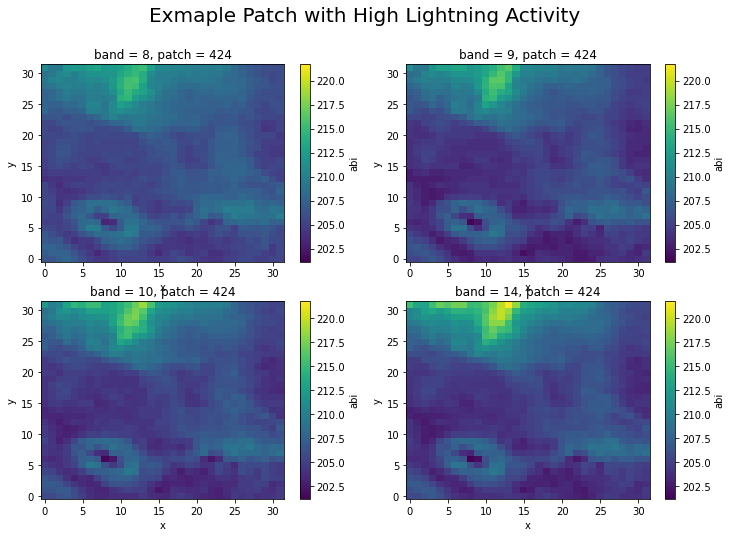

In [10]:
high_lc_indices = np.argwhere(train.flash_counts.values > 100).flatten() # indices with more than 100 lightning counts
no_lc_indices = np.argwhere(train.flash_counts.values == 0).flatten() # indices with no lightning counts

index = high_lc_indices[205]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range  
vmax = train['abi'][index,:,:,:].max()

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch with High Lightning Activity', fontsize=20)

Areas without lightning activity often exibit a much larger BT range throughout the channel column, particularily the longwave window (Band 14) which often has much higher values with clear skies.

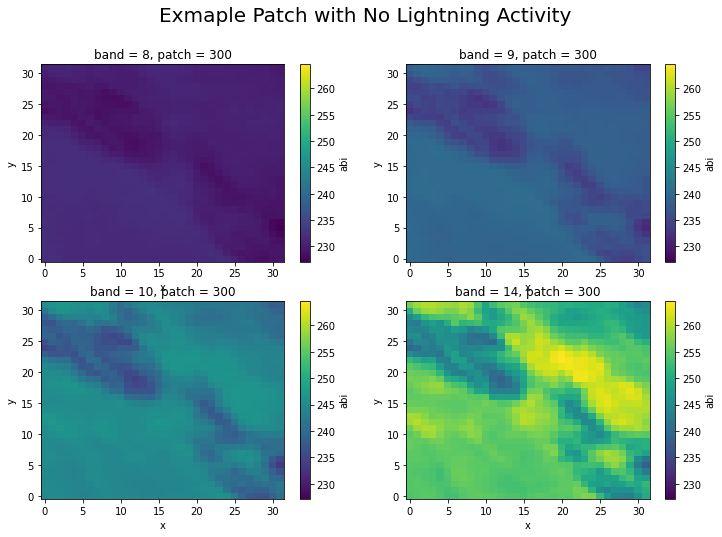

In [11]:
index = no_lc_indices[300]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range
vmax = train['abi'][index,:,:,:].max() # set min/max plotting range

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch with No Lightning Activity', fontsize=20)

This pattern is also noted when taking the mean value of each patch across the dataset.

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


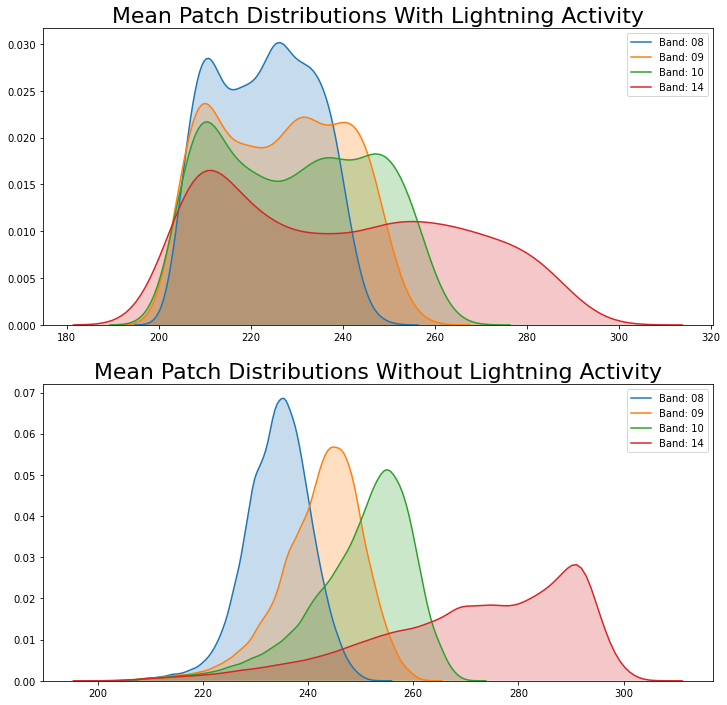

In [12]:
lc_train = train.isel(patch=high_lc_indices) # all patch data with lightning counts (above threshold)
no_lc_train = train.isel(patch=no_lc_indices) # all patch data without lightning activity
mean_patches_lc = lc_train.abi.mean(dim=('x','y')) # mean BT of each patch
mean_patches_no_lc = no_lc_train.abi.mean(dim=('x','y')) # mean BT of each patch

fig, ax = plt.subplots(2,1, figsize=(12,12))
for i,lab in enumerate(['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']*2):
    if i < 4:
        sns.kdeplot(mean_patches_lc[:,i], ax=ax[0], label=lab, shade=True).set_title(
            'Mean Patch Distributions With Lightning Activity', fontsize=22)
    else:
        sns.kdeplot(mean_patches_no_lc[:,i-4], ax=ax[1], label=lab, shade=True).set_title(
            'Mean Patch Distributions Without Lightning Activity', fontsize=22)

### Data Transforms
Discuss any transforms or normalizations that may be needed for this dataset. Remember to fit a scaler only to the training data and then apply it on testing and validation.

In [17]:
# Visual of input variable before and after transform
# Example of data transform procedure for dataset

In [27]:
train_in.shape, train_out.shape

((212604, 32, 32, 4), (212604,))

In [28]:
np.unique(train_out, return_counts=True)

(array([0, 1]), array([134992,  77612]))

In [7]:
%%time
# get numpy arrays of patch data for each band (this also converts all flash_counts to binary classes)
train_in, train_out = prepare_data(train) 
val_in, val_out = prepare_data(val)

# scale data
scaler = MinMaxScaler2D()
scaled_train_in = scaler.fit_transform(train_in)
scaled_val_in = scaler.transform(val_in)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


CPU times: user 18 s, sys: 5.58 s, total: 23.5 s
Wall time: 23.3 s


In [25]:
# declare ResNet (residual network from the goes16i module) and list the default parameters
# Any of these parameters can be overridden
# note using larger batch sizes here can cause memory errors
resNet_mod = ResNet(epochs=5, batch_size=512)
vars(resNet_mod)

{'min_filters': 16,
 'filter_width': 3,
 'filter_growth_rate': 2,
 'min_data_width': 4,
 'hidden_activation': 'relu',
 'output_activation': 'sigmoid',
 'use_dropout': False,
 'pooling': 'mean',
 'dropout_alpha': 0.0,
 'data_format': 'channels_last',
 'optimizer': 'adam',
 'learning_rate': 0.001,
 'loss': 'mse',
 'metrics': None,
 'leaky_alpha': 0.1,
 'batch_size': 512,
 'epochs': 5,
 'sgd_momentum': 0.99,
 'model': None,
 'parallel_model': None,
 'time_history': <goes16ci.models.TimeHistory at 0x7f5b30eafe50>,
 'loss_history': <goes16ci.models.LossHistory at 0x7f5b30eafe90>,
 'verbose': 0}

In [26]:
%%time
# Fit model and print architecture
resNet_mod.fit(scaled_train_in, train_out, scaled_val_in, val_out)
resNet_mod.model.summary()

{'loss': 0.08068365603685379, 'val_loss': 0.32102611660957336}
{'loss': 0.06800338625907898, 'val_loss': 0.09726528823375702}
{'loss': 0.06419813632965088, 'val_loss': 0.1143796369433403}
{'loss': 0.06291566044092178, 'val_loss': 0.08270972222089767}
{'loss': 0.0610259510576725, 'val_loss': 0.14803758263587952}
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          [(None, 32, 32, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   592         scn_input[0][0]                  
__________________________________________________________________________________________________
bn_res_00_a (BatchNormalization (None, 32, 32, 16)   64          conv2d[0][0] 

## Baseline ResNet Evaluation Metrics
We trained on binary output data, but output probabilities before converting to class. This allows us to evaluate regressed and classified metrics:


| Type | Metric | Value to beat |
| ------------- | :----:|:-------|
|  Regressed   ||   
|              | RMSE: |0.328|
|              | R2: |0.567 |
|              | Hellenger Distance: |0.501|
|||
| Classified   |||
|              | Heidke Skill Score: |0.705|
|              | Peirce Skill Score:  |0.713|
|              | Brier Score: |0.143|
|              | Brier Skill Score: |0.402|
|              | AUC: |0.856|

In [27]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = resNet_mod.predict(scaled_val_in).reshape(val_out.shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [4]:
# Metric functions
from sklearn.metrics import confusion_matrix, mean_squared_error, brier_score_loss, roc_auc_score

import numpy as np

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def brier_score(y_true, y_pred):
    return brier_score_loss(y_true, y_pred)

def brier_skill_score(y_true, y_pred):
    
    model_brier_score = mean_squared_error(y_true, y_pred)
    climo_brier_score = mean_squared_error(y_true, np.ones(y_true.size) * y_true.sum() / y_true.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    return model_brier_skill_score

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def peirce_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (no * no).sum() / n ** 2)

def heidke_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (nf * no).sum() / n ** 2)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

In [29]:
# Example regressed metrics
def print_regress_metrics(T, Y):
    print('RMSE: {}'.format(np.round(root_mean_squared_error(T, Y),3)))
    print('R squared: {}'.format(np.round(r2_corr(T, Y),3)))
    print('Hellenger Distance: {}'.format(np.round(hellinger_distance(T, Y),3)))

def class_metrics(T, Y):
    return {'heidke_skill_score': heidke_skill_score(T, Y),
            'peirce_skill_score': peirce_skill_score(T, Y),
            'brier_score': brier_score(T, Y),
            'brier_skill_score': brier_skill_score(T, Y),
            'roc_auc_score': roc_auc_score(T, Y)}
    
# Example classified metrics
def print_class_metrics(T, Y):
    results = class_metrics(T, Y)
    print('Heidke Skill Score: {}'.format(np.round(results['heidke_skill_score'],3)))
    print('Pierce Skill Score: {}'.format(np.round(results['peirce_skill_score'],3)))
    print('Brier Score: {}'.format(np.round(results['brier_score'],3)))
    print('Brier Skill Score: {}'.format(np.round(results['brier_skill_score'],3)))
    print('AUC: {}'.format(np.round(results['roc_auc_score'],3)))
    
print_regress_metrics(val_out, preds)
print()
print_class_metrics(val_out, binary_preds)

RMSE: 0.385
R squared: 0.402
Hellenger Distance: 0.387

Heidke Skill Score: 0.528
Pierce Skill Score: 0.517
Brier Score: 0.221
Brier Skill Score: 0.074
AUC: 0.759


## Interpretation
Description of interpretation methods for problem

In [18]:
# Include examples of interpretation code

## Hackathon Challenges

### Monday
* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

In [12]:
train_in, train_out = prepare_data(train) 
val_in, val_out = prepare_data(val)

In [15]:
Xtrain, Ttrain = train_in.reshape(train_in.shape[0], np.prod(train_in.shape[1:]))[:10_000], train_out[:10_000]
Xval, Tval = val_in.reshape(val_in.shape[0], np.prod(val_in.shape[1:]))[:10_000], val_out[:10_000]
Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape

((10000, 4096), (10000,), (10000, 4096), (10000,))

In [174]:
# Standardize data using new scalers - standard and minmax
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Standardize using Standard Scaler - this uses the mean and standard deviation

In [153]:
# scale data
scaler = StandardScaler()
scaler.fit(Xtrain)
scaled_train_in = scaler.transform(Xtrain)
scaled_val_in = scaler.transform(Xval)

In [167]:
%%time
# Import the Logistic Regression model
from sklearn.linear_model import LogisticRegression

# Fit the model and run prediction
model = LogisticRegression(max_iter = 300)
model.fit(scaled_train_in, Ttrain)
preds = model.predict(scaled_val_in)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 1min 39s, sys: 5.97 s, total: 1min 45s
Wall time: 27.5 s


In [168]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [169]:
# Example regressed metrics
print('With Standardizing using Standard Scaler')
print('RMSE: {}'.format(np.round(root_mean_squared_error(Tval, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(Tval, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(Tval, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(Tval, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(Tval, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(Tval, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(Tval, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(Tval, binary_preds),3)))

With Standardizing using Standard Scaler
RMSE: 0.45
R squared: 0.298
Hellenger Distance: 0.002
Heidke Skill Score: 0.538
Pierce Skill Score: 0.513
Brier Score: 0.202
Brier Skill Score: 0.118
AUC: 0.757


### Now try the MinMax Scaler

In [183]:
# scale data
scaler = MinMaxScaler()
scaler.fit(Xtrain)
scaled_train_in = scaler.transform(Xtrain)
scaled_val_in = scaler.transform(Xval)

In [184]:
%%time
# Import the Logistic Regression model
from sklearn.linear_model import LogisticRegression

# Fit the model and run prediction
model = LogisticRegression(max_iter = 300)
model.fit(scaled_train_in, Ttrain)
preds = model.predict(scaled_val_in)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 1min 40s, sys: 5.95 s, total: 1min 46s
Wall time: 27.7 s


In [185]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
binary_preds = np.where(preds >= binary_threshold, 1, 0)

# Example regressed metrics
print('With Standardizing using MinMaxScaler')
print('RMSE: {}'.format(np.round(root_mean_squared_error(Tval, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(Tval, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(Tval, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(Tval, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(Tval, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(Tval, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(Tval, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(Tval, binary_preds),3)))

With Standardizing using MinMaxScaler
RMSE: 0.446
R squared: 0.307
Hellenger Distance: 0.001
Heidke Skill Score: 0.546
Pierce Skill Score: 0.522
Brier Score: 0.199
Brier Skill Score: 0.133
AUC: 0.761


### Without any standardization of the data

In [181]:
%%time
# Fit model and print architecture
model = LogisticRegression(max_iter = 300)
model.fit(Xtrain, Ttrain)
preds = model.predict(Xval)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 1min 41s, sys: 5.21 s, total: 1min 46s
Wall time: 27.7 s


In [182]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
binary_preds = np.where(preds >= binary_threshold, 1, 0)

# Example regressed metrics
print('Without Standardizing')
print('RMSE: {}'.format(np.round(root_mean_squared_error(Tval, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(Tval, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(Tval, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(Tval, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(Tval, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(Tval, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(Tval, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(Tval, binary_preds),3)))

Without Standardizing
RMSE: 0.445
R squared: 0.307
Hellenger Distance: 0.002
Heidke Skill Score: 0.547
Pierce Skill Score: 0.522
Brier Score: 0.198
Brier Skill Score: 0.135
AUC: 0.761


---

## Exploratory Dimensionality Reduction

In [16]:
components = PCA(n_components=2).fit_transform(Xtrain)
embeded = TSNE(n_components=2).fit_transform(Xtrain)

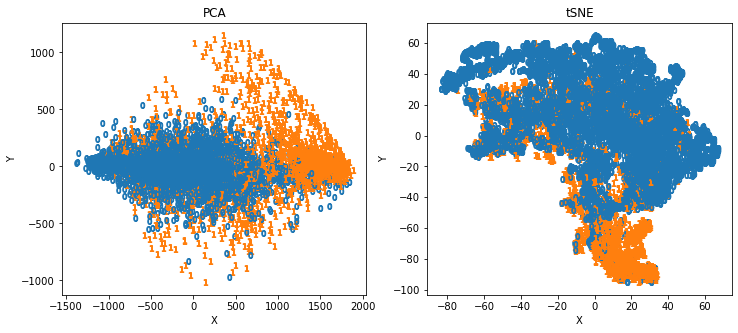

In [17]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)

for i, T in enumerate(Ttrain):
    ax.plot(components[i, 0], components[i, 1], 
            marker='${}$'.format(str(T)), c=COLORS[T])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('PCA')

ax = fig.add_subplot(1, 2, 2)

for i, T in enumerate(Ttrain):
    ax.plot(embeded[i, 0], embeded[i, 1], 
            marker='${}$'.format(str(T)), c=COLORS[T])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('tSNE')

plt.show()

### Decision Tree Classifier

In [18]:
results = []

criterion = ['gini', 'entropy']
max_depth = np.arange(5, 16)

f = FloatProgress(min=0, max=(len(criterion) * len(max_depth)))
display(f)
for criteria, depth in itertools.product(criterion, max_depth):

    dtc = DecisionTreeClassifier(criterion=criteria, max_depth=depth)
    dtc = dtc.fit(Xtrain, Ttrain)
    Y = dtc.predict(Xval)
    
    result = class_metrics(Y, Tval)

    result['criteria'] = criteria
    result['max_depth'] = depth
    
    results.append(result)

    f.value += 1

FloatProgress(value=0.0, max=22.0)

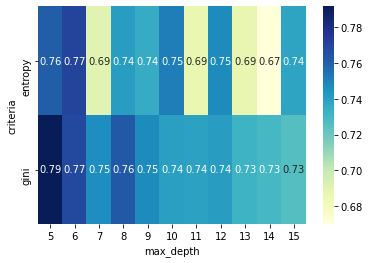

In [19]:
res = pd.DataFrame(results)
res_pivot = res.pivot(index='criteria', columns='max_depth', values='roc_auc_score')
sns.heatmap(res_pivot, annot=True, cmap='YlGnBu');

In [20]:
gini = res[res['criteria'] == 'gini']['roc_auc_score'].values
entropy = res[res['criteria'] == 'entropy']['roc_auc_score'].values

Gini has µ AUC: 0.748 and µ Entropy: 0.726


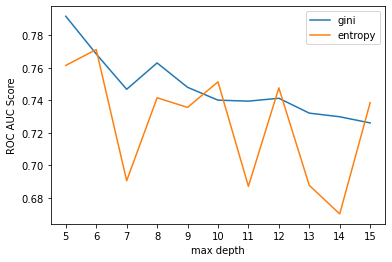

In [21]:
plt.plot(max_depth, gini, label='gini');
plt.plot(max_depth, entropy, label='entropy');

plt.xlabel('max depth'); plt.ylabel('ROC AUC Score')
plt.xticks(max_depth); plt.legend();

print(f'Gini has µ AUC: {gini.mean():.3f} and µ Entropy: {entropy.mean():.3f}')

In [22]:
np.unique(Tval, return_counts=True)

(array([0, 1]), array([8673, 1327]))

### Random Forest Classifier

In [23]:
rfc_results = []

l_estimators = np.arange(10, 101, 10)
criterion = ['gini']
max_depth = np.arange(5, 16)

f = FloatProgress(min=0, max=(len(l_estimators) * len(criterion) * len(max_depth)))
display(f)
for estimators, criteria, depth in itertools.product(l_estimators, criterion, max_depth):

    rfc = RandomForestClassifier(n_estimators=estimators, criterion=criteria, max_depth=depth)
    rfc = rfc.fit(Xtrain, Ttrain)
    Y = rfc.predict(Xval)
    
    result = class_metrics(Y, Tval)
    
    result['estimators'] = estimators
    result['criteria'] = criteria
    result['max_depth'] = depth
    
    rfc_results.append(result)

    f.value += 1

FloatProgress(value=0.0, max=110.0)

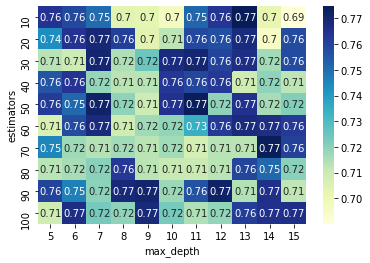

In [24]:
res = pd.DataFrame(rfc_results)
res_pivot = res.pivot(index='estimators', columns='max_depth', values='roc_auc_score')
sns.heatmap(res_pivot, annot=True, cmap='YlGnBu');

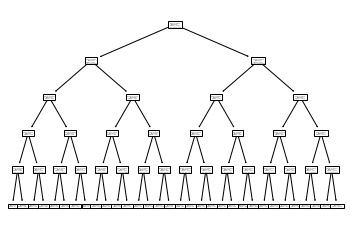

In [94]:
plot_tree(dtc);

### Tuesday
* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

In [58]:
cluster = LocalCluster(processes=True, threads_per_worker=2)
client = Client(cluster)
fs = s3fs.S3FileSystem(anon=True)

In [59]:
%%time
train_files, val_files, test_files = split_data_files()
train, val, test = map(merge_data, [train_files, val_files, test_files])

CPU times: user 18.4 s, sys: 1min 13s, total: 1min 31s
Wall time: 7min 32s


In [60]:
client.shutdown()

In [62]:
in_train, out_train = prepare_data(train, convert_binary=False)
in_val  , out_val   = prepare_data(val, convert_binary=False)
in_test , out_test  = prepare_data(test, convert_binary=False)

In [63]:
interval = 10
Xtrain, Ttrain = in_train[::interval], out_train[::interval].reshape(-1, 1)
Xval  , Tval   = in_val[::interval*4], out_val[::interval*4].reshape(-1, 1)
Xtest , Ttest  = in_test[::interval*4] , out_test[::interval*4].reshape(-1, 1)
Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((21261, 32, 32, 4),
 (21261, 1),
 (4985, 32, 32, 4),
 (4985, 1),
 (4979, 32, 32, 4),
 (4979, 1))

### Fully Connected Neural Networks

In [78]:
class TrainLogger(tf.keras.callbacks.Callback):
    
    def __init__(self, n_epochs, step=10):
        self.step = step
        self.n_epochs = n_epochs
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.step == 0:
            print(f"epoch: {epoch}, loss: {logs['loss']:7.5f}")
        elif epoch + 1 == self.n_epochs:
            print(f"epoch: {epoch}, loss: {logs['loss']:7.5f}")
            print('finished!')

class NeuralNetwork():
    def __init__(self, n_inputs, n_hiddens_list, n_outputs, activation='tanh'):
        
        if not isinstance(n_hiddens_list, list):
            raise Exception(
                f'{type(self).__name__}: n_hiddens_list must be a list.')
        
        self.n_inputs = n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        
        X = tf.keras.Input(shape=n_inputs)
        Z = tf.keras.layers.Flatten()(X)
        for i, units in enumerate(n_hiddens_list):
            Z = tf.keras.layers.Dense(units, activation=activation)(Z)
        Y = tf.keras.layers.Dense(n_outputs)(Z)

        self.model = tf.keras.Model(inputs=X, outputs=Y)
        
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None
        
        self.history = None
        self.training_time = None
    
    def __repr__(self):
        str = f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs})'
        if self.history:
            str += f"\n  Final objective value is {self.history['loss'][-1]:.5f} in {self.training_time:.4f} seconds."
        else:
            str += '  Network is not trained.'
        return str
    
    def _setup_standardize(self, X, T):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

        if self.Tmeans is None:
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            self.Tconstant = self.Tstds == 0
            self.TstdsFixed = copy.copy(self.Tstds)
            self.TstdsFixed[self.Tconstant] = 1
            
    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _standardizeT(self, T):
        result = (T - self.Tmeans) / self.TstdsFixed
        result[:, self.Tconstant] = 0.0
        return result

    def _unstandardizeT(self, Ts):
        return self.Tstds * Ts + self.Tmeans
    
    def train(self, X, T, n_epochs, batch_size, validation_data=None, 
              method='sgd', verbose=False, learning_rate=0.001):
        """Use Keras Functional API to train model"""
        
        self._setup_standardize(X, T)
        X = self._standardizeX(X)
        T = self._standardizeT(T)
    
        try:
            algo = [tf.keras.optimizers.SGD, tf.keras.optimizers.Adam][[
                'sgd', 'adam'].index(method)]
        except:
            raise Exception(
                f"train: method={method} not one of 'sgd' or 'adam'")

        self.model.compile(optimizer=algo(learning_rate),
                      loss=tf.keras.losses.MSE, 
                      metrics=[tf.keras.metrics.RootMeanSquaredError()])
        
        callback = [TrainLogger(n_epochs, step=100)] if verbose else None
        if validation_data is not None:
            validation_data = self._standardizeX(validation_data[0]), self._standardizeT(validation_data[1])
        
        start_time = time.time()
        self.history = self.model.fit(X, T, batch_size=batch_size, epochs=n_epochs,
                                      verbose=0, callbacks=callback, 
                                      validation_data=validation_data).history
        self.training_time = time.time() - start_time
        return self
    
    def use(self, X):
        X = self._standardizeX(X)
        Y = self._unstandardizeT(self.model.predict(X))
        return Y

#### Hyperparameters
- Architecture
    - Loss Function
    - Optimization Method
        - Learning Rate
    - Number of Hidden Layers
    - Number of Hidden Units / Layer
- Training Epochs
- Training Batch Size
- *Standardization Techniques*

#### Contrasting Optimization Algorithms

adam finished training in 690.2406542301178 seconds
sgd finished training in 670.5284600257874 seconds


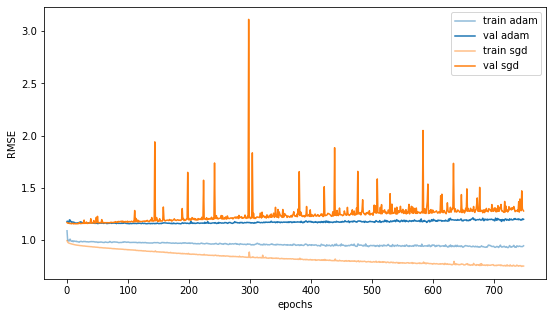

In [87]:
plt.figure(figsize=(9, 5))

for i, method in enumerate(['adam', 'sgd']):
    nnet = NeuralNetwork(Xtrain.shape[1:], [10], Ttrain.shape[1], activation='tanh')
    nnet.train(Xtrain, Ttrain, 750, 64, validation_data=(Xval, Tval), 
               method=method, verbose=False, learning_rate=0.001)
    print(f'{method} finished training in {nnet.training_time} seconds')
    plt.plot(nnet.history['root_mean_squared_error'], label='train '+method,
             color=COLORS[i], alpha=0.5)
    plt.plot(nnet.history['val_root_mean_squared_error'], label='val '+method,
             color=COLORS[i])
    
plt.legend()
plt.xlabel('epochs'); plt.ylabel('RMSE');

#### Contrasting Learning Rates

trained in 123.33489489555359 seconds
trained in 123.33327078819275 seconds
trained in 123.27644157409668 seconds


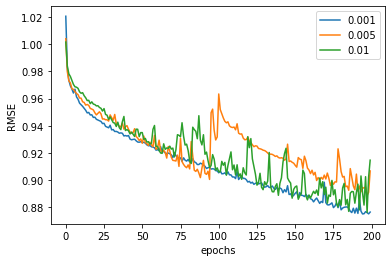

In [35]:
for rho in [0.001, 0.005, 0.01]:
    nnet = NeuralNetwork(Xtrain.shape[1:], [10], Ttrain.shape[1], activation='tanh')
    nnet.train(Xtrain, Ttrain, 200, 64, method='sgd', verbose=False, learning_rate=rho)
    print(f'trained in {nnet.training_time} seconds')
    plt.plot(nnet.history['root_mean_squared_error'], label=rho)
    
plt.legend()
plt.xlabel('epochs'); plt.ylabel('RMSE');

In [122]:
nnet = NeuralNetwork(Xtrain.shape[1:], [10], Ttrain.shape[1], activation='tanh')
nnet.model.summary()

Model: "model_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_72 (InputLayer)        [(None, 32, 32, 4)]       0         
_________________________________________________________________
flatten_69 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_155 (Dense)            (None, 10)                40970     
_________________________________________________________________
dense_156 (Dense)            (None, 1)                 11        
Total params: 40,981
Trainable params: 40,981
Non-trainable params: 0
_________________________________________________________________


epoch: 0, loss: 0.98849
epoch: 100, loss: 0.81079
epoch: 200, loss: 0.74863
epoch: 300, loss: 0.79279
epoch: 400, loss: 0.65551
epoch: 500, loss: 0.62958
epoch: 600, loss: 0.59594
epoch: 700, loss: 0.57551
epoch: 800, loss: 0.55786
epoch: 900, loss: 0.54412
epoch: 1000, loss: 0.62163
epoch: 1100, loss: 0.59982
epoch: 1200, loss: 0.58452
epoch: 1300, loss: 0.57641
epoch: 1400, loss: 0.56687
epoch: 1500, loss: 0.57254
epoch: 1600, loss: 0.54550
epoch: 1700, loss: 0.67387
epoch: 1800, loss: 0.65323
epoch: 1900, loss: 0.64480
epoch: 1999, loss: 0.63064
finished!
trained in 1228.0434379577637 seconds


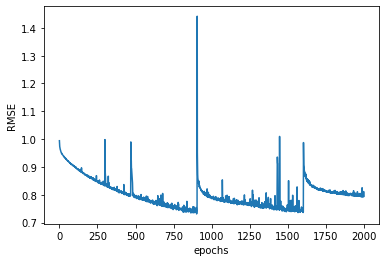

In [46]:
nnet = NeuralNetwork(Xtrain.shape[1:], [10], Ttrain.shape[1], activation='tanh')
nnet.train(Xtrain, Ttrain, 2000, 64, method='sgd', verbose=True, learning_rate=0.001)

print(f'trained in {nnet.training_time} seconds')

plt.plot(nnet.history['root_mean_squared_error'])
plt.xlabel('epochs'); plt.ylabel('RMSE');

In [49]:
root_mean_squared_error(Ttest, nnet.use(Xtest))

24.649174805284265

### Hidden Layer Architectures

In [29]:
layers = [[0]] + [[nu] * nl for nu in [10, 20, 50, 100] for nl in range(1, 4)]

train_percentage = []
test_percentage = []
top = float('inf')

f = FloatProgress(min=0, max=len(layers))
display(f)
for layer in layers:
    nnet = NeuralNetwork(Xtrain.shape[1:], layer, Ttrain.shape[1], activation='tanh')
    nnet.train(Xtrain, Ttrain, 750, 64, method='sgd', verbose=False, learning_rate=0.001)

    Y = nnet.use(Xtrain)
    train_percentage.append(root_mean_squared_error(Ttrain, Y))
    
    Y = nnet.use(Xtest)
    temp = root_mean_squared_error(Ttest, Y)
    test_percentage.append(temp)
    
    if temp < top:
        best_nnet = nnet
        top = temp
    
    f.value += 1

FloatProgress(value=0.0, max=13.0)

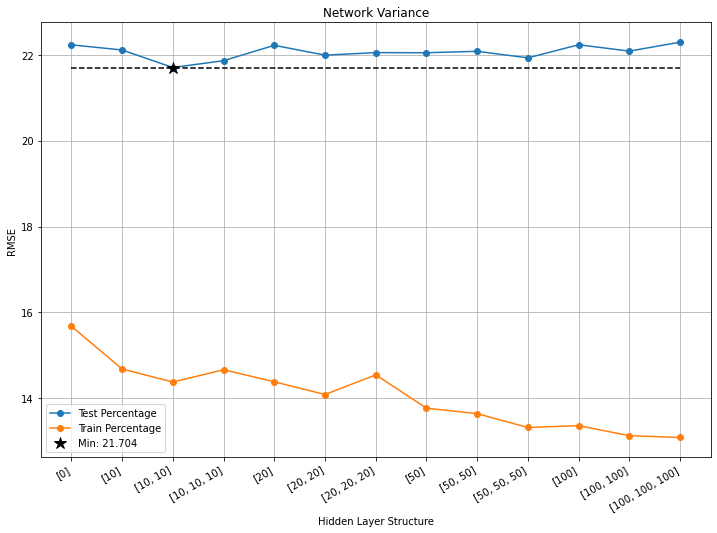

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(layers) - 1, linestyle='dashed')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(layers)), layers, rotation=30, horizontalalignment='right')

plt.legend(('Test Percentage', 'Train Percentage', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

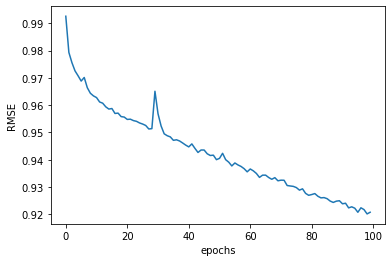

In [47]:
plt.plot(best_nnet.history['root_mean_squared_error'])    
plt.xlabel('epochs'); plt.ylabel('RMSE');

## Convolutional Neural Network

In [280]:
class ConvolutionalNeuralNetwork():
    def __init__(self, n_inputs, n_units_in_conv_layers,
                 kernels_size_and_stride, n_outputs,
                 activation='relu', classification=False):
        
        if not isinstance(n_units_in_conv_layers, list):
            raise Exception(
                f'{type(self).__name__}: n_units_in_conv_layers must be a list.')
        tf.keras.backend.clear_session()
        
        self.n_inputs = n_inputs
        self.n_units_in_conv_layers = n_units_in_conv_layers
        self.kernels_size_and_stride = kernels_size_and_stride
        self.n_outputs = n_outputs
        self.classification = classification
        
        X = tf.keras.Input(shape=n_inputs)
        Z = X
        for kernels, units in zip(kernels_size_and_stride, n_units_in_conv_layers):
            Z = tf.keras.layers.Conv2D(units, kernels, activation=activation,
                                       padding='same')(Z)
            Z = tf.keras.layers.MaxPooling2D((2, 2))(Z)
        Y = tf.keras.layers.Dense(n_outputs, activation='softmax')(tf.keras.layers.Flatten()(Z))

        self.model = tf.keras.Model(inputs=X, outputs=Y)
        
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None
        
        self.history = None
        self.training_time = None
    
    def __repr__(self):
        str = f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs})'
        if self.history:
            str += f"\n  Final objective value is {self.history['loss'][-1]:.5f} in {self.training_time:.4f} seconds."
        else:
            str += '  Network is not trained.'
        return str
    
    def _setup_standardize(self, X, T):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

        if self.Tmeans is None:
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            self.Tconstant = self.Tstds == 0
            self.TstdsFixed = copy.copy(self.Tstds)
            self.TstdsFixed[self.Tconstant] = 1
            
    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _standardizeT(self, T):
        result = (T - self.Tmeans) / self.TstdsFixed
        result[:, self.Tconstant] = 0.0
        return result

    def _unstandardizeT(self, Ts):
        return self.Tstds * Ts + self.Tmeans
    
    def train(self, X, T, n_epochs, batch_size, validation_data=None,
              method='sgd', verbose=False, learning_rate=0.001):
        """Use Keras Functional API to train model"""

        self._setup_standardize(X, T)
        X = self._standardizeX(X)
        
        if self.classification:
            loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
            metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC(name=None)]
        else:
            T = self._standardizeT(T)
            loss = tf.keras.losses.MSE
            metrics = [tf.keras.metrics.RootMeanSquaredError()]
            
        try:
            algo = [tf.keras.optimizers.SGD, tf.keras.optimizers.Adam][[
                'sgd', 'adam'].index(method)]
        except:
            raise Exception(
                f"train: method={method} not one of 'sgd' or 'adam'")

        self.model.compile(optimizer=algo(learning_rate), loss=loss, metrics=metrics)
        
        if validation_data is not None:
            validation_data = self._standardizeX(validation_data[0]), (self._standardizeT(validation_data[1]) if not self.classification 
                                                                       else validation_data[1])
            
        callback = [TrainLogger(n_epochs, step=100)] if verbose else None

        start_time = time.time()
        self.history = self.model.fit(X, T, batch_size=batch_size, epochs=n_epochs,
                                      verbose=0, callbacks=callback, 
                                      validation_data=validation_data).history
        self.training_time = time.time() - start_time
        return self
    
    def use(self, X):
        X = self._standardizeX(X)
        Y = self.model.predict(X)
        if self.classification:
            Y = tf.one_hot(tf.argmax(Y, axis=1), depth=Y.shape[1])
        else:
            Y = self._unstandardizeT(Y)
        return Y

### Regression CNN

In [234]:
nnet = ConvolutionalNeuralNetwork(Xtrain.shape[1:], [10, 10], [(3, 3), (3, 3)],
                     Ttrain.shape[1], activation='relu')
nnet.model.summary()

Model: "model_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_165 (InputLayer)       [(None, 32, 32, 4)]       0         
_________________________________________________________________
conv2d_198 (Conv2D)          (None, 32, 32, 10)        370       
_________________________________________________________________
max_pooling2d_198 (MaxPoolin (None, 16, 16, 10)        0         
_________________________________________________________________
conv2d_199 (Conv2D)          (None, 16, 16, 10)        910       
_________________________________________________________________
max_pooling2d_199 (MaxPoolin (None, 8, 8, 10)          0         
_________________________________________________________________
flatten_162 (Flatten)        (None, 640)               0         
_________________________________________________________________
dense_249 (Dense)            (None, 2)                 12

adam finished training in 119.83472013473511 seconds
sgd finished training in 117.39003229141235 seconds


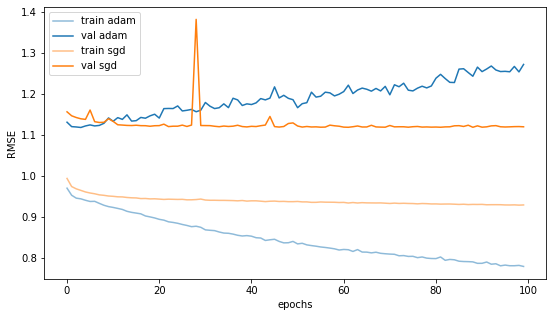

In [133]:
plt.figure(figsize=(9, 5))

for i, method in enumerate(['adam', 'sgd']):
    nnet = ConvolutionalNeuralNetwork(Xtrain.shape[1:], [10, 10], [(3, 3), (3, 3)],
                         Ttrain.shape[1], activation='relu')
    nnet.train(Xtrain, Ttrain, 100, 64, validation_data=(Xval, Tval), 
               method=method, verbose=False, learning_rate=0.001)
    print(f'{method} finished training in {nnet.training_time} seconds')
    plt.plot(nnet.history['root_mean_squared_error'], label='train '+method,
             color=COLORS[i], alpha=0.5)
    plt.plot(nnet.history['val_root_mean_squared_error'], label='val '+method,
             color=COLORS[i])
    
plt.legend()
plt.xlabel('epochs'); plt.ylabel('RMSE');

#### Classification CNN

In [135]:
in_train, out_train = prepare_data(train, convert_binary=True)
in_val  , out_val   = prepare_data(val, convert_binary=True)
in_test , out_test  = prepare_data(test, convert_binary=True)

In [174]:
interval = 10
depth = len(np.unique(out_train))
# one hot encoded lightning values are denoted [0, 1], and [1, 0] otherwise
Xtrain, Ttrain = in_train[::interval], tf.one_hot(out_train[::interval], depth=depth).numpy()
Xval  , Tval   = in_val[::interval*4], tf.one_hot(out_val[::interval*4], depth=depth).numpy()
Xtest , Ttest  = in_test[::interval*4], tf.one_hot(out_test[::interval*4], depth=depth).numpy()
Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((21261, 32, 32, 4),
 (21261, 2),
 (4985, 32, 32, 4),
 (4985, 2),
 (4979, 32, 32, 4),
 (4979, 2))

In [168]:
# Use number of classes as the output dimension
nnet = ConvolutionalNeuralNetwork(Xtrain.shape[1:], [10, 10], [(3, 3), (3, 3)],
                     Ttrain.shape[1], activation='relu', classification=True)
nnet.model.summary()

Model: "model_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_89 (InputLayer)        [(None, 32, 32, 4)]       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 10)        370       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 16, 16, 10)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 16, 16, 10)        910       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 8, 8, 10)          0         
_________________________________________________________________
flatten_86 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_173 (Dense)            (None, 2)                 128

#### Contrasting Optimization Algorithms

adam finished training in 171.02126026153564 seconds
sgd finished training in 167.99273562431335 seconds


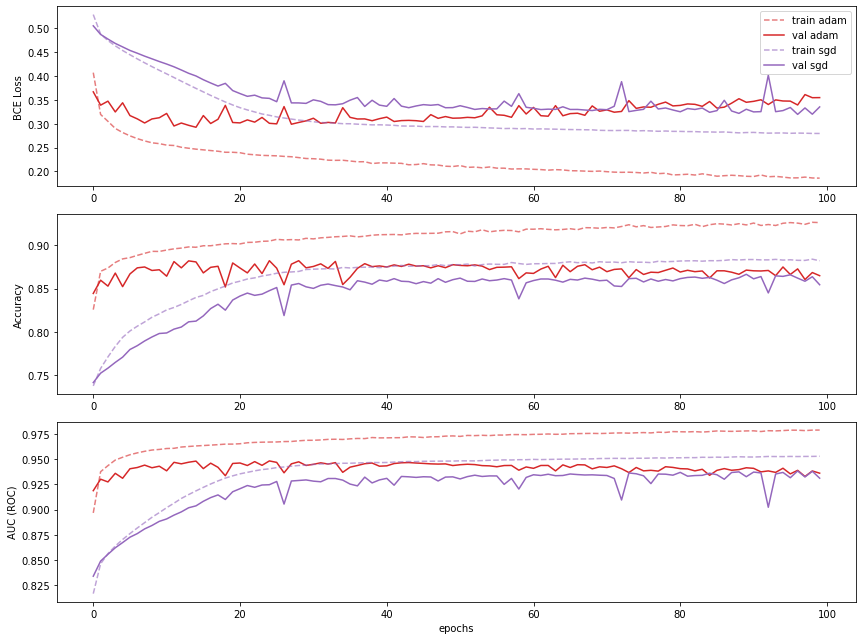

In [275]:
def plot_metric(ax, metric, lab, i):
    ax.plot(nnet.history[metric], '--', label='train '+lab,
             color=COLORS[i+3], alpha=0.6)
    ax.plot(nnet.history['val_' + metric], label='val '+lab,
             color=COLORS[i+3])
    
fig, axs = plt.subplots(3, 1, figsize=(12, 9))

for i, method in enumerate(['adam', 'sgd']):
    nnet = ConvolutionalNeuralNetwork(Xtrain.shape[1:], [10, 10], [(3, 3), (3, 3)],
                         len(np.unique(Ttrain)), activation='relu', classification=True)
    nnet.train(Xtrain, Ttrain, 100, 64, validation_data=(Xval, Tval), 
               method=method, verbose=False, learning_rate=0.001)
    
    print(f'{method} finished training in {nnet.training_time} seconds')
    
    plot_metric(axs[0], 'loss', method, i)
    plot_metric(axs[1], 'categorical_accuracy', method, i)
    plot_metric(axs[2], 'auc', method, i)
    
axs[0].legend();
axs[0].set_ylabel('BCE Loss');
axs[1].set_ylabel('Accuracy');
axs[2].set_xlabel('epochs'); axs[2].set_ylabel('AUC (ROC)');
fig.tight_layout();

#### Contrasting Activation Functions

*From above plots: train for 45 epochs with the Adam optimizer.*

relu finished training in 69.93883156776428 seconds
tanh finished training in 69.98908376693726 seconds
elu finished training in 69.66465616226196 seconds


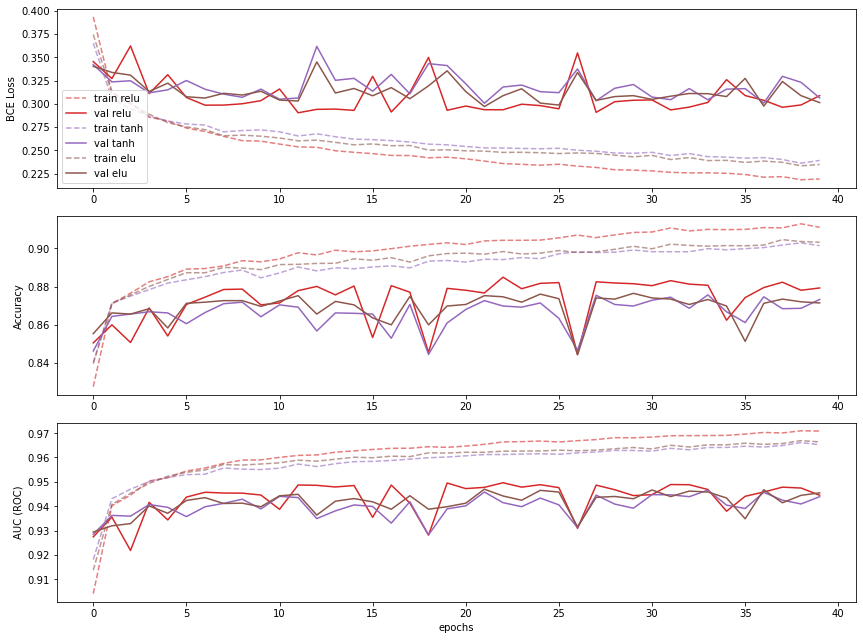

In [289]:
fig, axs = plt.subplots(3, 1, figsize=(12, 9))

for i, activation in enumerate(['relu', 'tanh', 'elu']):
    nnet = ConvolutionalNeuralNetwork(Xtrain.shape[1:], [10, 10], [(3, 3), (3, 3)],
                         len(np.unique(Ttrain)), activation=activation, classification=True)
    nnet.train(Xtrain, Ttrain, 40, 64, validation_data=(Xval, Tval), 
               method='adam', verbose=False, learning_rate=0.001)
    
    print(f'{activation} finished training in {nnet.training_time} seconds')
    
    plot_metric(axs[0], 'loss', activation, i)
    plot_metric(axs[1], 'categorical_accuracy', activation, i)
    plot_metric(axs[2], 'auc', activation, i)
    
axs[0].legend();
axs[0].set_ylabel('BCE Loss');
axs[1].set_ylabel('Accuracy');
axs[2].set_xlabel('epochs'); axs[2].set_ylabel('AUC (ROC)');
fig.tight_layout();

#### Contrasting Hidden Unit/Kernel Dimensions

In [307]:
def percent_correct(actual, predicted):
    return 100 * np.mean(actual == predicted)

layers = [[nu] * nl for nu in [10, 20, 50, 100] for nl in range(1, 5)]
kernels = [[(3, 3)]*len(l) for l in layers]

train_percentage = []
test_percentage = []
top = 0

f = FloatProgress(min=0, max=len(layers))
display(f)
for layer, kernel in zip(layers, kernels):
    nnet = ConvolutionalNeuralNetwork(Xtrain.shape[1:], layer, kernel,
                         len(np.unique(Ttrain)), activation='relu', classification=True)
    nnet.train(Xtrain, Ttrain, 40, 64, method='adam', verbose=False, learning_rate=0.001)

    Y = nnet.use(Xtrain)
    train_percentage.append(percent_correct(Ttrain, Y))
    
    Y = nnet.use(Xtest)
    temp = percent_correct(Ttest, Y)
    test_percentage.append(temp)
    
    if temp > top:
        best_nnet = nnet
        top = temp
    
    f.value += 1

FloatProgress(value=0.0, max=16.0)

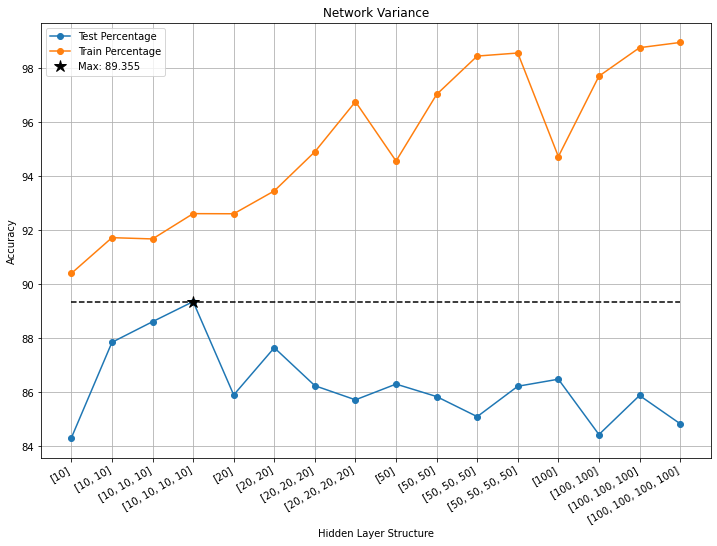

In [308]:
plt.figure(figsize=(12, 8))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmax(test_percentage)
top_v = test_percentage[top_index]

plt.hlines(top_v, 0, len(layers) - 1, linestyle='dashed')
plt.plot(top_index, top_v, 'k*', markersize=12)
plt.xticks(range(len(layers)), layers, rotation=30, horizontalalignment='right')

plt.legend(('Test Percentage', 'Train Percentage', 'Max: {:.3f}'.format(top_v)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('Accuracy');

In [309]:
best_nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 10)        370       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 10)        910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 10)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 10)          910       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 10)          0     

### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

In [25]:
# Wednesday's code goes here


2.2.0


### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them 

In [22]:
# Thursday's code goes here


## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.